# Preliminaries

In [1]:
import numpy as np
import pandas as pd

from sklearn.externals import joblib
import pickle

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
rcParams['legend.loc'] = 'best'

In [3]:
import scipy.stats
import random

## Charging the data

In [4]:
#  Need:

# DATA.map --> .map file generated by plink from original data file

# SNP_QC.npy --> SNP passing Quality Controls (QC).
# trainpresel_QC_union -> SNP preselected, after QC

# SNP_all_balls.npy -> file with, that associates a window on DNA for each SNP in SNP_QC[trainpresel_QC_union]
# there are 3 columns (chrom, init_window, end_window) 


# feat_select_LR_QC_rand_HWcontrol_all_FOLD.npy 
# feat_select_LGBM_QC_rand_HWcontrol_all_FOLD.npy 
# feat_select_ResNet_QC_rand_HWcontrol_all_FOLD.npy 
# feat_select_rand_QC_rand_HWcontrol_all_FOLD.npy 
# 
# are files with the feature importance weights:
# (weight for LR and rand, gain for LGBM, permutation feature selection for ResNet) 





In [5]:
# GWAS:

# weight_Jostins_norm.npy --> log(abs(OR)) for OR given by Jostins et al.

# SNP_Jostins_balls.npy -> same as SNP_all_balls.npy, for Jostins SNP
# SNP_Jostins_balls_order.npy -> SNP_Jostins_balls but ordered for importance (log(abs(OR)))

In [6]:
DATAmap=pd.read_table('DATAjune.map',header=None)
ALL_SNPs_names=DATAmap[1].values
ALL_SNPs_chrs=DATAmap[0].values
ALL_SNPs_pos=DATAmap[3].values

In [7]:
SNP_balls=np.load('SNP_all_balls.npy')
SNP_Jostins_balls=np.load('SNP_Jostins_balls.npy')
SNP_Jostins_balls_order=np.load('SNP_Jostins_balls_order.npy')

In [8]:
All_SNP_QC=np.load('SNP_QC.npy')

presel_QC=np.unique((np.load('trainpresel_QC_union.npy')/2).astype(int))

SNP_QC=All_SNP_QC[presel_QC]

In [9]:
# Number of fold for each model
Nfold=10


In [10]:
weight_LR=np.load('feat_select_LR_QC_rand_HWcontrol_all_FOLD.npy')
gain_LGBM=np.load('feat_select_LGBM_QC_rand_HWcontrol_all_FOLD.npy')
gain_resnet=np.load('feat_select_ResNet_QC_rand_HWcontrol_all_FOLD.npy')
random_coeff=np.load('feat_select_rand_QC_rand_HWcontrol_all_FOLD.npy')
weight_Jostins_norm=np.load('weight_Jostins_norm.npy')


## Finding base on the positions

In [11]:
# Defining globally defined windows of 500Kb starting from the beginning of DNA
size_wind=500000
# size_wind=200000
# size_wind=100000

In [12]:
init_chrom=np.zeros((23,2))
init_fin=np.zeros(23)
for i in range(23):
    init_chrom[i,0]=np.sum(SNP_balls[:,0]<i+1).astype(int)
for i in range(1,23):  
    init_fin[i]=SNP_balls[(init_chrom[i,0]-1).astype(int),2]
init_fin=init_fin.astype(int)

init_chrom=init_chrom.astype(int)

correction_new_chrom=2*size_wind
for i in range(1,23):
    aaa=0
    for j in range(0,i+1):
        aaa=init_fin[j]+aaa+correction_new_chrom
    init_chrom[i,1]=aaa

In [13]:
SNP_balls_centers=np.zeros((SNP_QC.shape[0],2))
SNP_balls_centers[:,0]=np.copy(SNP_balls[SNP_QC][:,0])
SNP_balls_centers[:,1]=np.copy((SNP_balls[SNP_QC][:,2]+SNP_balls[SNP_QC][:,1])/2)
SNP_balls_centers=SNP_balls_centers.astype(int)

In [14]:
# coord of SNPs preselected, in terms of basis from beginning DNA
xxx=np.zeros(SNP_balls_centers.shape[0])
for i in range(SNP_balls_centers.shape[0]):
    xxx[i]=SNP_balls_centers[i,1]+init_chrom[SNP_balls_centers[i,0]-1,1]

In [15]:
SNP_Jostins_balls_centers=np.zeros((SNP_Jostins_balls_order.shape[0],2))
SNP_Jostins_balls_centers[:,0]=np.copy(SNP_Jostins_balls_order[:,0])
SNP_Jostins_balls_centers[:,1]=np.copy((SNP_Jostins_balls_order[:,2]+SNP_Jostins_balls_order[:,1])/2)
SNP_Jostins_balls_centers=SNP_Jostins_balls_centers.astype(int)

In [16]:
# coord of SNPs GWAS, in terms of basis from beginning DNA
xxx_jost=np.zeros(SNP_Jostins_balls_centers.shape[0])
for i in range(xxx_jost.shape[0]):
    xxx_jost[i]=SNP_Jostins_balls_centers[i,1]+init_chrom[SNP_Jostins_balls_centers[i,0]-1,1]

## Building windows

In [17]:
LLL=xxx[-1]
x_basis_borders=np.arange(0,LLL+size_wind,size_wind)
x_basis=x_basis_borders[:-1]+size_wind/2

x_basis_borders_shift=np.arange(0,LLL+size_wind,size_wind)+size_wind/2
x_basis_shift=x_basis_borders_shift[:-1]+size_wind/2

## Position base for presel and jostins

In [18]:
# I build the mean on the folds of the coefficients 
y_LR_prel=np.mean(weight_LR,axis=0)
y_LGBM_prel=np.mean(gain_LGBM,axis=0)
y_ResNet_prel=np.mean(gain_resnet,axis=0)
y_Jost_prel=weight_Jostins_norm
y_rand_prel=np.mean(random_coeff,axis=0)

In [19]:
# In which window, starting from the beginning, each SNP preselected is located
y_presel_pos=np.zeros(y_LR_prel.shape[0])

for j in range(y_LR_prel.shape[0]):
    y_presel_pos[j]=np.nonzero((xxx[j]>x_basis_borders))[0][-1]

y_presel_pos=y_presel_pos.astype(int)

# In which window, starting from the beginning, each SNP preselected is located - shifted by half window
y_presel_pos_shift=np.zeros(y_LR_prel.shape[0])

for j in range(y_LR_prel.shape[0]):
    y_presel_pos_shift[j]=np.nonzero((xxx[j]>x_basis_borders_shift))[0][-1]

y_presel_pos_shift=y_presel_pos_shift.astype(int)

In [20]:
print('Number of independent windows for preselected SNPs: ',
      np.unique(y_presel_pos).shape[0])

Number of independent windows for preselected SNPs:  1748


In [21]:
# In which window, starting from the beginning, each SNP of GWAS is located
y_Jost_pos=np.zeros(y_Jost_prel.shape[0])

for j in range(y_Jost_prel.shape[0]):
    y_Jost_pos[j]=np.nonzero((xxx_jost[j]>x_basis_borders))[0][-1]

y_Jost_pos=y_Jost_pos.astype(int)

# In which window, starting from the beginning, each SNP of Jostins is located - shifted
y_Jost_pos_shift=np.zeros(y_Jost_prel.shape[0])

for j in range(y_Jost_prel.shape[0]):
    y_Jost_pos_shift[j]=np.nonzero((xxx_jost[j]>x_basis_borders_shift))[0][-1]

y_Jost_pos_shift=y_Jost_pos_shift.astype(int)

In [22]:
y_basis_count=np.zeros(x_basis.shape[0])
for i in range(x_basis.shape[0]):
    y_basis_count[i]=np.sum(y_presel_pos==i)
    
y_presel_count=y_basis_count[y_basis_count>0]

(array([   0.,  100.,  200.,  300.,  400.,  500.]),
 <a list of 6 Text yticklabel objects>)

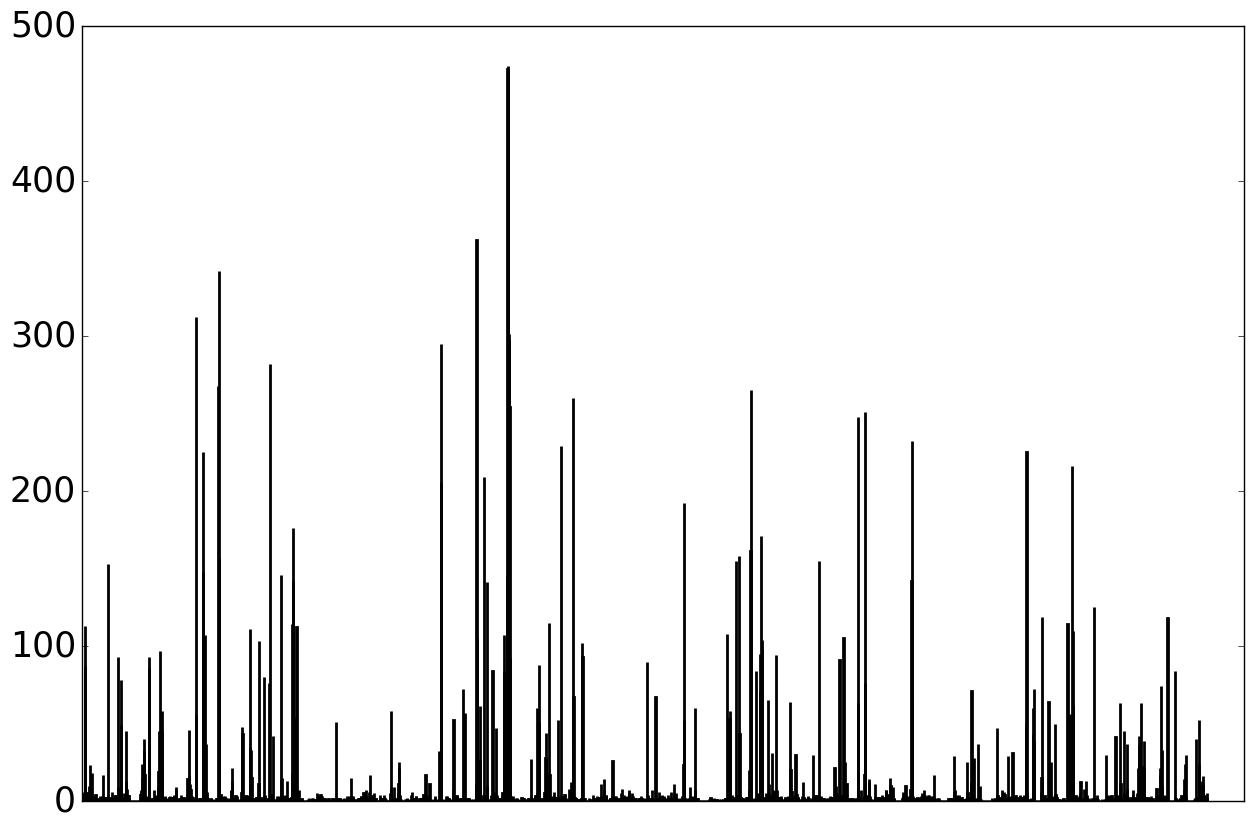

In [23]:
# Density of SNP on the genome
plt.hist(y_presel_pos,bins=x_basis.shape[0],linewidth=2)
plt.xticks([])  
plt.yticks(fontsize=25)

# Models on windows base

### On the mean for each model

In [24]:
# For the vectors which represents the mean of the coefficients for each model
# We define new vector y_LR, ..., of lenght equal to the number of the windows, and with each entry the biggest
# coefficient of the corresponding model, relative to that window

# # Choose the strategy: 
# 1) max of SNP coeff in each window
# 2) sum of SNP coeff in each window
strategy=1

In [25]:
def y_model_mean(y_model_prel,y_presel_pos_choice):

    y_model_prun=[y_model_prel[0]]
    y_presel_pos_prun=[y_presel_pos_choice[0]]

    for i in range(1,y_presel_pos_choice.shape[0]):
        if np.sum(y_presel_pos_choice[i]==np.asarray(y_presel_pos_prun))==0:
            y_model_prun.append(y_model_prel[i])
            y_presel_pos_prun.append(y_presel_pos_choice[i])
        else:
            i_p=np.nonzero(y_presel_pos_choice[i]==np.asarray(y_presel_pos_prun))[0][0]
            if strategy ==1:
                y_model_prun[i_p]=np.max((y_model_prun[i_p],y_model_prel[i]))
            if strategy ==2:
                y_model_prun[i_p]=(y_model_prun[i_p]+y_model_prel[i])



    y_presel_pos_prun=np.asarray(y_presel_pos_prun)

    y_model_mean=np.zeros(x_basis.shape[0])
    for j in range(len(y_presel_pos_prun)):
        y_model_mean[y_presel_pos_prun[j]]=np.abs(y_model_prun[j])
        
    return y_model_mean

In [26]:
def y_model(y_model_prel_all,y_presel_pos_choice):

    y_model=np.zeros((y_model_prel_all.shape[0],x_basis.shape[0]))

    for z in range(y_model_prel_all.shape[0]):

        y_model_prun=[y_model_prel_all[z,0]]
        y_presel_pos_choice_prun=[y_presel_pos_choice[0]]

        for i in range(1,y_presel_pos_choice.shape[0]):
            if np.sum(y_presel_pos_choice[i]==np.asarray(y_presel_pos_choice_prun))==0:
                y_model_prun.append(y_model_prel_all[z,i])
                y_presel_pos_choice_prun.append(y_presel_pos_choice[i])
            else:
                i_p=np.nonzero(y_presel_pos_choice[i]==np.asarray(y_presel_pos_choice_prun))[0][0]
                if strategy ==1:
                    y_model_prun[i_p]=np.max((y_model_prun[i_p],y_model_prel_all[z,i]))
                if strategy ==2:
                    y_model_prun[i_p]=(y_model_prun[i_p]+y_model_prel_all[z,i])


        y_presel_pos_choice_prun=np.asarray(y_presel_pos_choice_prun)


        for j in range(len(y_presel_pos_choice_prun)):
            y_model[z,y_presel_pos_choice_prun[j]]=np.abs(y_model_prun[j])
            
    return y_model

#### LR

In [27]:
y_LR_mean=y_model_mean(y_LR_prel,y_presel_pos)
y_LR_mean_shift=y_model_mean(y_LR_prel,y_presel_pos_shift)

#### LGBM

In [28]:
y_LGBM_mean=y_model_mean(y_LGBM_prel,y_presel_pos)
y_LGBM_mean_shift=y_model_mean(y_LGBM_prel,y_presel_pos_shift)

#### ResNet

In [29]:
y_ResNet_mean=y_model_mean(y_ResNet_prel,y_presel_pos)
y_ResNet_mean_shift=y_model_mean(y_ResNet_prel,y_presel_pos_shift)

#### Random

In [30]:
y_rand_mean=y_model_mean(y_rand_prel,y_presel_pos)
y_rand_mean_shift=y_model_mean(y_rand_prel,y_presel_pos_shift)

#### GWAS

In [31]:
y_Jost=y_model_mean(y_Jost_prel,y_Jost_pos)
y_Jost_shift=y_model_mean(y_Jost_prel,y_Jost_pos_shift)

### On each fold

In [32]:
# uniform the notation
y_LR_prel_all=weight_LR
y_LGBM_prel_all=gain_LGBM
y_ResNet_prel_all=gain_resnet
y_rand_prel_all=random_coeff

In [33]:
y_all_models={}

#### LR

In [34]:
y_LR=y_model(y_LR_prel_all,y_presel_pos)
y_LR_shift=y_model(y_LR_prel_all,y_presel_pos_shift)

y_all_models['y_LR']=y_LR
y_all_models['y_LR_shift']=y_LR_shift

#### LGBM

In [36]:
y_LGBM=y_model(y_LGBM_prel_all,y_presel_pos)
y_LGBM_shift=y_model(y_LGBM_prel_all,y_presel_pos_shift)

y_all_models['y_LGBM']=y_LGBM
y_all_models['y_LGBM_shift']=y_LGBM_shift

#### ResNet

In [37]:
y_ResNet=y_model(y_ResNet_prel_all,y_presel_pos)
y_ResNet_shift=y_model(y_ResNet_prel_all,y_presel_pos_shift)

y_all_models['y_ResNet']=y_ResNet
y_all_models['y_ResNet_shift']=y_ResNet_shift

#### Random

In [38]:
y_rand=y_model(y_rand_prel_all,y_presel_pos)
y_rand_shift=y_model(y_rand_prel_all,y_presel_pos_shift)

y_all_models['y_rand']=y_rand
y_all_models['y_rand_shift']=y_rand_shift

## Creating Ordered Lists

In [39]:
def y_model_orders_mean(y_model_mean):
    Max_SNP_act=np.sum(y_model_mean>0)
    y_model_orders_mean=np.zeros(y_model_mean.shape)
    for i in range(1,Max_SNP_act+1):
        cutoff_model=np.sort(y_model_mean)[::-1][:i][-1]
        y_model_orders_mean[np.nonzero(y_model_mean==cutoff_model)[0]]=i
    y_model_orders_mean[(1-y_model_orders_mean>0)]=Max_SNP_act+1

    return y_model_orders_mean


In [40]:
def y_model_orders(y_model):
    y_model_orders=np.zeros(y_model.shape)
    for i in range(Nfold):
        Max_SNP_act=np.sum(y_model[i,:]>0)
        for j in range(1,Max_SNP_act+1):
            cutoff_model=np.sort(y_model[i,:])[::-1][:j][-1]
            y_model_orders[i,np.nonzero(y_model[i,:]==cutoff_model)[0]]=j
        y_model_orders[i,(1-y_model_orders[i,:]>0)]=Max_SNP_act+1
    return y_model_orders
    

### For the mean

In [41]:
y_all_models_orders_mean={}

y_all_models_orders_mean['y_LR_orders_mean']=y_model_orders_mean(y_LR_mean)
y_all_models_orders_mean['y_LR_orders_mean_shift']=y_model_orders_mean(y_LR_mean_shift)

y_all_models_orders_mean['y_LGBM_orders_mean']=y_model_orders_mean(y_LGBM_mean)
y_all_models_orders_mean['y_LGBM_orders_mean_shift']=y_model_orders_mean(y_LGBM_mean_shift)

y_all_models_orders_mean['y_ResNet_orders_mean']=y_model_orders_mean(y_ResNet_mean)
y_all_models_orders_mean['y_ResNet_orders_mean_shift']=y_model_orders_mean(y_ResNet_mean_shift)

y_all_models_orders_mean['y_rand_orders_mean']=y_model_orders_mean(y_rand_mean)
y_all_models_orders_mean['y_rand_orders_mean_shift']=y_model_orders_mean(y_rand_mean_shift)

y_all_models_orders_mean['y_jost_orders']=y_model_orders_mean(y_Jost)
y_all_models_orders_mean['y_jost_orders_shift']=y_model_orders_mean(y_Jost_shift)

### For each fold

In [42]:
y_all_models_orders={}

y_all_models_orders['y_LR_orders']=y_model_orders(y_LR)
y_all_models_orders['y_LR_orders_shift']=y_model_orders(y_LR_shift)

y_all_models_orders['y_LGBM_orders']=y_model_orders(y_LGBM)
y_all_models_orders['y_LGBM_orders_shift']=y_model_orders(y_LGBM_shift)

y_all_models_orders['y_ResNet_orders']=y_model_orders(y_ResNet)
y_all_models_orders['y_ResNet_orders_shift']=y_model_orders(y_ResNet_shift)

y_all_models_orders['y_rand_orders']=y_model_orders(y_rand)
y_all_models_orders['y_rand_orders_shift']=y_model_orders(y_rand_shift)


# Spearman Statistics

In [43]:
def spearm_diff_models_stat(model1,model2,cutoff):
    y_model1_orders=y_all_models_orders['y_'+model1+'_orders']
    y_model2_orders=y_all_models_orders['y_'+model2+'_orders']
    y_model1_orders_shift=y_all_models_orders['y_'+model1+'_orders_shift']
    y_model2_orders_shift=y_all_models_orders['y_'+model2+'_orders_shift']
    
    
    spearm_model=np.zeros(Nfold)
    
    print('List compared on a base of n. windows: ', cutoff)
    for i in range(Nfold):
        keep=((y_model1_orders[i,:]<cutoff)+(y_model2_orders[i,:]<cutoff))>0
        spearm_model_shift_1=scipy.stats.spearmanr(y_model1_orders[i,keep],
                                                   y_model2_orders[i,keep])[0]

        keep=((y_model1_orders_shift[i,:]<cutoff)+(y_model2_orders_shift[i,:]<cutoff))>0
        spearm_model_shift_2=scipy.stats.spearmanr(y_model1_orders_shift[i,keep],
                                                   y_model2_orders_shift[i,keep])[0]


        keep=((y_model1_orders[i,1:]<cutoff)+(y_model2_orders_shift[i,:-1]<cutoff))>0
        spearm_model_shift_3=scipy.stats.spearmanr(y_model1_orders[i,1:][keep],
                                                   y_model2_orders_shift[i,:-1][keep])[0]

        keep=((y_model1_orders[i,:-1]<cutoff)+(y_model2_orders_shift[i,1:]<cutoff))>0
        spearm_model_shift_4=scipy.stats.spearmanr(y_model1_orders[i,:-1][keep],
                                                   y_model2_orders_shift[i,1:][keep])[0]

        spearm_model[i]=max(spearm_model_shift_1,spearm_model_shift_2,spearm_model_shift_3,spearm_model_shift_4)




    print('Spearman R -- %s - %s (with shift) for size %d : %f +/- %f ' % (model1, model2, size_wind,np.mean(spearm_model),np.std(spearm_model)) )
    return spearm_model

In [44]:
def spearm_same_model_stat(model1,cutoff):
    y_model1_orders=y_all_models_orders['y_'+model1+'_orders']
    y_model2_orders=np.copy(y_model1_orders)
    y_model1_orders_shift=y_all_models_orders['y_'+model1+'_orders_shift']
    y_model2_orders_shift=np.copy(y_model1_orders_shift)
    
    
    spearm_model=np.zeros(int(Nfold*(Nfold-1)/2))
    k=0
    
    print('List compared on a base of n. windows: ', cutoff)
    for i in range(Nfold-1):
        for j in range(i+1,Nfold):
            keep=((y_model1_orders[i,:]<cutoff)+(y_model2_orders[j,:]<cutoff))>0
            spearm_model_shift_1=scipy.stats.spearmanr(y_model1_orders[i,keep],
                                                       y_model2_orders[j,keep])[0]

            keep=((y_model1_orders_shift[i,:]<cutoff)+(y_model2_orders_shift[j,:]<cutoff))>0
            spearm_model_shift_2=scipy.stats.spearmanr(y_model1_orders_shift[i,keep],
                                                       y_model2_orders_shift[j,keep])[0]


            keep=((y_model1_orders[i,1:]<cutoff)+(y_model2_orders_shift[j,:-1]<cutoff))>0
            spearm_model_shift_3=scipy.stats.spearmanr(y_model1_orders[i,1:][keep],
                                                       y_model2_orders_shift[j,:-1][keep])[0]

            keep=((y_model1_orders[i,:-1]<cutoff)+(y_model2_orders_shift[j,1:]<cutoff))>0
            spearm_model_shift_4=scipy.stats.spearmanr(y_model1_orders[i,:-1][keep],
                                                       y_model2_orders_shift[j,1:][keep])[0]

            spearm_model[k]=max(spearm_model_shift_1,spearm_model_shift_2,spearm_model_shift_3,spearm_model_shift_4)


            k=k+1


    print('Spearman R -- %s - %s (with shift) for size %d : %f +/- %f ' % (model1, model1, size_wind,np.mean(spearm_model),np.std(spearm_model)) )
    return spearm_model

## Intra-Model

### LR - LR

In [45]:
spearm_LR_400=spearm_same_model_stat('LR',400)

List compared on a base of n. windows:  400
Spearman R -- LR - LR (with shift) for size 500000 : 0.403114 +/- 0.029253 


In [46]:
spearm_LR_800=spearm_same_model_stat('LR',800)

List compared on a base of n. windows:  800
Spearman R -- LR - LR (with shift) for size 500000 : 0.462813 +/- 0.017867 


### LGBM - LGBM

In [47]:
spearm_LGBM_400=spearm_same_model_stat('LGBM',400)

List compared on a base of n. windows:  400
Spearman R -- LGBM - LGBM (with shift) for size 500000 : 0.424149 +/- 0.025452 


In [48]:
spearm_LGBM_800=spearm_same_model_stat('LGBM',800)

List compared on a base of n. windows:  800
Spearman R -- LGBM - LGBM (with shift) for size 500000 : 0.451489 +/- 0.019218 


### ResNet - ResNet

In [49]:
spearm_ResNet_400=spearm_same_model_stat('ResNet',400)

List compared on a base of n. windows:  400
Spearman R -- ResNet - ResNet (with shift) for size 500000 : 0.259320 +/- 0.028529 


In [50]:
spearm_ResNet_800=spearm_same_model_stat('ResNet',800)

List compared on a base of n. windows:  800
Spearman R -- ResNet - ResNet (with shift) for size 500000 : 0.403488 +/- 0.018187 


### Random - Random

In [51]:
spearm_rand_400=spearm_same_model_stat('rand',400)

List compared on a base of n. windows:  400
Spearman R -- rand - rand (with shift) for size 500000 : 0.134651 +/- 0.022769 


In [52]:
spearm_rand_800=spearm_same_model_stat('rand',800)

List compared on a base of n. windows:  800
Spearman R -- rand - rand (with shift) for size 500000 : 0.199496 +/- 0.019514 


## Extra-Model

### LR - LGBM

In [53]:
spearm_LR_LGBM_800=spearm_diff_models_stat('LR','LGBM',800)

List compared on a base of n. windows:  800
Spearman R -- LR - LGBM (with shift) for size 500000 : 0.367554 +/- 0.030663 


### LGBM - ResNet

In [54]:
spearm_LGBM_ResNet_800=spearm_diff_models_stat('LGBM','ResNet',800)

List compared on a base of n. windows:  800
Spearman R -- LGBM - ResNet (with shift) for size 500000 : 0.331456 +/- 0.020096 


### LR - ResNet

In [55]:
spearm_LR_ResNet_800=spearm_diff_models_stat('LR','ResNet',800)

List compared on a base of n. windows:  800
Spearman R -- LR - ResNet (with shift) for size 500000 : 0.263063 +/- 0.022929 


### LR - rand

In [56]:
spearm_LR_rand_800=spearm_diff_models_stat('LR','rand',800)

List compared on a base of n. windows:  800
Spearman R -- LR - rand (with shift) for size 500000 : -0.060597 +/- 0.008681 


### LGBM - rand

In [57]:
spearm_LGBM_rand_800=spearm_diff_models_stat('LGBM','rand',800)

List compared on a base of n. windows:  800
Spearman R -- LGBM - rand (with shift) for size 500000 : 0.025587 +/- 0.015878 


### ResNet - rand

In [58]:
spearm_ResNet_rand_800=spearm_diff_models_stat('ResNet','rand',800)

List compared on a base of n. windows:  800
Spearman R -- ResNet - rand (with shift) for size 500000 : 0.022900 +/- 0.022031 


## Combining models

In [59]:
#  Define combined features
#  as window-feature by appeareance in the intersection
#  in case of simultaneous apprearance I take higher weight (product of weights of different models)

In [60]:
def blend_models(model1,model2):
    y_model1=y_all_models['y_'+model1]
    y_model2=y_all_models['y_'+model2]
    y_model1_orders=y_all_models_orders['y_'+model1+'_orders']
    y_model2_orders=y_all_models_orders['y_'+model2+'_orders']
    blend_models=np.zeros(y_model1_orders.shape)

    for i in range(Nfold):
        MMM=min(y_model1_orders[i,:].max(),y_model2_orders[i,:].max())
        intersect_blend_1=[]

        lll=[]
        for k in range(1,int(MMM)):
            lll=np.nonzero(1*(y_model1_orders[i,:]<=k)*(y_model2_orders[i,:]<=k))[0]
            ggg=np.setdiff1d(np.asarray(lll),np.asarray(intersect_blend_1))
            if ggg.shape[0]>0:
                if ggg.shape[0]>1:
                    weight_part_inter=np.zeros(ggg.shape[0])
                    for h in range(ggg.shape[0]):
                        weight_part_inter[h]=y_model1[i,ggg[h]]*y_model2[i,ggg[h]]
                    ggg=ggg[np.argsort(weight_part_inter)[::-1]]    
                for z in range(ggg.shape[0]):
                    intersect_blend_1.append(ggg[z])
        for d in range(len(intersect_blend_1)):
            blend_models[i,intersect_blend_1[d]]=d+1
        blend_models[i,blend_models[i,:]==0]=len(intersect_blend_1)+1
    return blend_models

### Combination LR - LGBM

In [61]:
blend_LR_LGBM=blend_models('LR','LGBM')

In [62]:
spearm_blend_LR_LGBM_400=np.zeros(int(Nfold*(Nfold-1)/2))
pears_blend_LR_LGBM_400=np.zeros(int(Nfold*(Nfold-1)/2))
k=0
for i in range(Nfold-1):
    for j in range(i+1,Nfold):
        keep=((blend_LR_LGBM[i,:]<400)+(blend_LR_LGBM[j,:]<400))>0
        spearm_blend_LR_LGBM_400[k]=scipy.stats.spearmanr(blend_LR_LGBM[i,keep],blend_LR_LGBM[j,keep])[0]
        
        k=k+1
        
print('Spearman R -- blend LR - LGBM for size %d : %f +/- %f ' % 
      (size_wind,np.mean(spearm_blend_LR_LGBM_400),np.std(spearm_blend_LR_LGBM_400)) )


Spearman R -- blend LR - LGBM for size 500000 : 0.418464 +/- 0.028819 


### Combination LR - ResNet

In [63]:
blend_LR_ResNet=blend_models('LR','ResNet')

In [64]:
spearm_blend_LR_ResNet_400=np.zeros(int(Nfold*(Nfold-1)/2))
pears_blend_LR_ResNet_400=np.zeros(int(Nfold*(Nfold-1)/2))
k=0
for i in range(Nfold-1):
    for j in range(i+1,Nfold):
        keep=((blend_LR_ResNet[i,:]<400)+(blend_LR_ResNet[j,:]<400))>0
        spearm_blend_LR_ResNet_400[k]=scipy.stats.spearmanr(blend_LR_ResNet[i,keep],blend_LR_ResNet[j,keep])[0]
        
        k=k+1
        

print('Spearman R -- blend LR - ResNet for size %d : %f +/- %f ' % 
      (size_wind,np.mean(spearm_blend_LR_ResNet_400),np.std(spearm_blend_LR_ResNet_400)) )

Spearman R -- blend LR - ResNet for size 500000 : 0.382229 +/- 0.024197 


### Combination ResNet - LGBM

In [65]:
blend_ResNet_LGBM=blend_models('ResNet','LGBM')

In [66]:
spearm_blend_ResNet_LGBM_400=np.zeros(int(Nfold*(Nfold-1)/2))
pears_blend_ResNet_LGBM_400=np.zeros(int(Nfold*(Nfold-1)/2))
k=0
for i in range(Nfold-1):
    for j in range(i+1,Nfold):
        keep=((blend_ResNet_LGBM[i,:]<400)+(blend_ResNet_LGBM[j,:]<400))>0
        spearm_blend_ResNet_LGBM_400[k]=scipy.stats.spearmanr(blend_ResNet_LGBM[i,keep],blend_ResNet_LGBM[j,keep])[0]
        
        k=k+1
        

print('Spearman R -- blend ResNet - LGBM for size %d : %f +/- %f ' % 
      (size_wind,np.mean(spearm_blend_ResNet_LGBM_400),np.std(spearm_blend_ResNet_LGBM_400)) )


Spearman R -- blend ResNet - LGBM for size 500000 : 0.438825 +/- 0.026346 


### Combination LR - LGBM - ResNet

In [67]:
y_LR_orders=y_all_models_orders['y_LR_orders']
y_LGBM_orders=y_all_models_orders['y_LGBM_orders']
y_ResNet_orders=y_all_models_orders['y_ResNet_orders']

blend_LR_LGBM_ResNet=np.zeros(y_LR_orders.shape)

for i in range(Nfold):
    MMM=min(y_LR_orders[i,:].max(),y_LGBM_orders[i,:].max(),y_ResNet_orders[i,:].max())
    intersect_blend_1=[]
    lll=[]
    for k in range(1,int(MMM)):
        lll=np.nonzero(1*(y_LR_orders[i,:]<=k)*(y_LGBM_orders[i,:]<=k)*(y_ResNet_orders[i,:]<=k))[0]
        ggg=np.setdiff1d(np.asarray(lll),np.asarray(intersect_blend_1))
        if ggg.shape[0]>0:
            if ggg.shape[0]>1:
                weight_part_inter=np.zeros(ggg.shape[0])
                for h in range(ggg.shape[0]):
                    weight_part_inter[h]=y_LR[i,ggg[h]]*y_LGBM[i,ggg[h]]*y_ResNet[i,ggg[h]]
                ggg=ggg[np.argsort(weight_part_inter)[::-1]]    
            for z in range(ggg.shape[0]):
                intersect_blend_1.append(ggg[z])
    for d in range(len(intersect_blend_1)):
        blend_LR_LGBM_ResNet[i,intersect_blend_1[d]]=d+1
    blend_LR_LGBM_ResNet[i,blend_LR_LGBM_ResNet[i,:]==0]=len(intersect_blend_1)+1

In [68]:
spearm_blend_LR_LGBM_ResNet_400=np.zeros(int(Nfold*(Nfold-1)/2))
pears_blend_LR_LGBM_ResNet_400=np.zeros(int(Nfold*(Nfold-1)/2))
k=0
for i in range(Nfold-1):
    for j in range(i+1,Nfold):
        keep=((blend_LR_LGBM_ResNet[i,:]<400)+(blend_LR_LGBM_ResNet[j,:]<400))>0
        spearm_blend_LR_LGBM_ResNet_400[k]=scipy.stats.spearmanr(blend_LR_LGBM_ResNet[i,keep],blend_LR_LGBM_ResNet[j,keep])[0]
        
        k=k+1
        

print('Spearman R -- blend LR - LGBM - ResNet for size %d : %f +/- %f ' % 
      (size_wind,np.mean(spearm_blend_LR_LGBM_ResNet_400),np.std(spearm_blend_LR_LGBM_ResNet_400)) )


Spearman R -- blend LR - LGBM - ResNet for size 500000 : 0.432633 +/- 0.023307 


## Plots - Tables

### Bar Plots

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 6 Text yticklabel objects>)

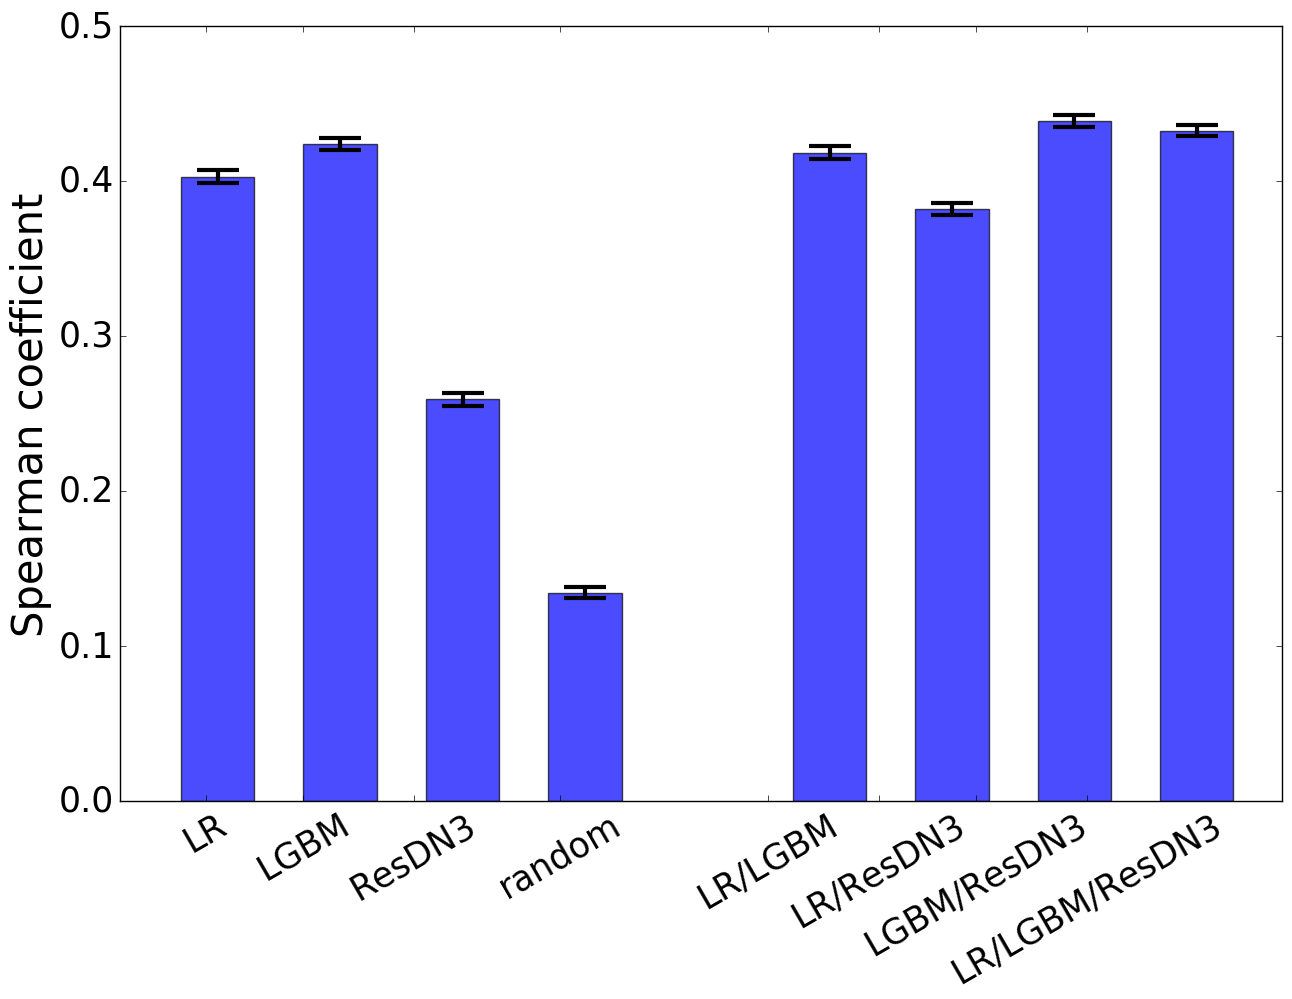

In [69]:
a_1m=np.mean(spearm_LR_400)
a_2m=np.mean(spearm_LGBM_400)
a_3m=np.mean(spearm_ResNet_400)
a_4m=np.mean(spearm_rand_400)

a_1e=np.std(spearm_LR_400)/np.sqrt(Nfold*(Nfold-1)/2)
a_2e=np.std(spearm_LGBM_400)/np.sqrt(Nfold*(Nfold-1)/2)
a_3e=np.std(spearm_ResNet_400)/np.sqrt(Nfold*(Nfold-1)/2)
a_4e=np.std(spearm_rand_400)/np.sqrt(Nfold*(Nfold-1)/2)

b_1m=np.mean(spearm_blend_LR_LGBM_400)
b_2m=np.mean(spearm_blend_LR_ResNet_400)
b_3m=np.mean(spearm_blend_ResNet_LGBM_400)
b_4m=np.mean(spearm_blend_LR_LGBM_ResNet_400)

b_1e=np.std(spearm_blend_LR_LGBM_400)/np.sqrt(Nfold*(Nfold-1)/2)
b_2e=np.std(spearm_blend_LR_ResNet_400)/np.sqrt(Nfold*(Nfold-1)/2)
b_3e=np.std(spearm_blend_ResNet_LGBM_400)/np.sqrt(Nfold*(Nfold-1)/2)
b_4e=np.std(spearm_blend_LR_LGBM_ResNet_400)/np.sqrt(Nfold*(Nfold-1)/2)

N = 9
Means = (a_1m, a_2m, a_3m, a_4m,  b_1m, b_2m, b_3m, b_4m)
Std = (a_1e, a_2e, a_3e, a_4e,  b_1e, b_2e, b_3e, b_4e)

ind = np.array([0,1,2,3,5,6,7,8])    # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, Means, width, 
             ecolor='k',capsize=15,alpha=0.7)
plt.errorbar(ind+width/2,Means,Std,color='k',linestyle='None',elinewidth=3,capsize=15,capthick=3)

ind_t=np.array([0.2,1,1.9,3.1,4.8,5.7,6.5,7.4])
plt.ylabel('Spearman coefficient',fontsize=30)
plt.axis((-0.5,9,0,0.5))
# plt.title('Spearman coefficient (400 features of each model)',fontsize=20)
plt.xticks(ind_t, ('LR', 'LGBM', 'ResDN3', 'random',  'LR/LGBM','LR/ResDN3','LGBM/ResDN3','LR/LGBM/ResDN3'),
           fontsize=25,ha='center',rotation=30,va='top')
plt.yticks(fontsize=25)


### Heatmaps

In [105]:
import seaborn as sns

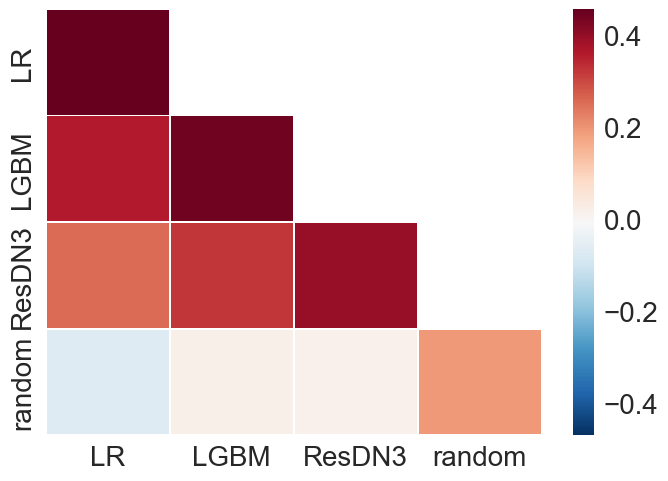

In [106]:
sns.set(font_scale=2)
aaa=np.array([[np.mean(spearm_LR_800),np.mean(spearm_LR_LGBM_800),np.mean(spearm_LR_ResNet_800),np.mean(spearm_LR_rand_800)],
              [np.mean(spearm_LR_LGBM_800),np.mean(spearm_LGBM_800),np.mean(spearm_LGBM_ResNet_800),np.mean(spearm_LGBM_rand_800)],
              [np.mean(spearm_LR_ResNet_800),np.mean(spearm_LGBM_ResNet_800),np.mean(spearm_ResNet_800),np.mean(spearm_ResNet_rand_800)],
              [np.mean(spearm_LR_rand_800),np.mean(spearm_LGBM_rand_800),np.mean(spearm_ResNet_rand_800),np.mean(spearm_rand_800)]])

mask = np.zeros_like(aaa)
mask[np.triu_indices_from(aaa,k=1)] = True
    
with sns.axes_style("white"):
    ax = sns.heatmap(aaa, mask=mask,linewidths=.5,
                     xticklabels=['LR','LGBM','ResDN3','random'],yticklabels=['LR','LGBM','ResDN3','random'])
    

# Comparison with Jostins

In [72]:
y_rand_orders=y_all_models_orders['y_rand_orders']

NMAX=1000

Jost_in_LR=np.zeros((Nfold,NMAX))
Jost_in_LGBM=np.zeros((Nfold,NMAX))
Jost_in_ResNet=np.zeros((Nfold,NMAX))
Jost_in_rand=np.zeros((Nfold,NMAX))

for i in range(Nfold):
    for nnn in range(NMAX):
        Max_ord=nnn+1
        Jost_in_LR[i,nnn]=np.sum((y_LR_orders[i,:]<=Max_ord)*(y_Jost>0))
        Jost_in_LGBM[i,nnn]=np.sum((y_LGBM_orders[i,:]<=Max_ord)*(y_Jost>0))
        Jost_in_ResNet[i,nnn]=np.sum((y_ResNet_orders[i,:]<=Max_ord)*(y_Jost>0))
        Jost_in_rand[i,nnn]=np.sum((y_rand_orders[i,:]<=Max_ord)*(y_Jost>0))



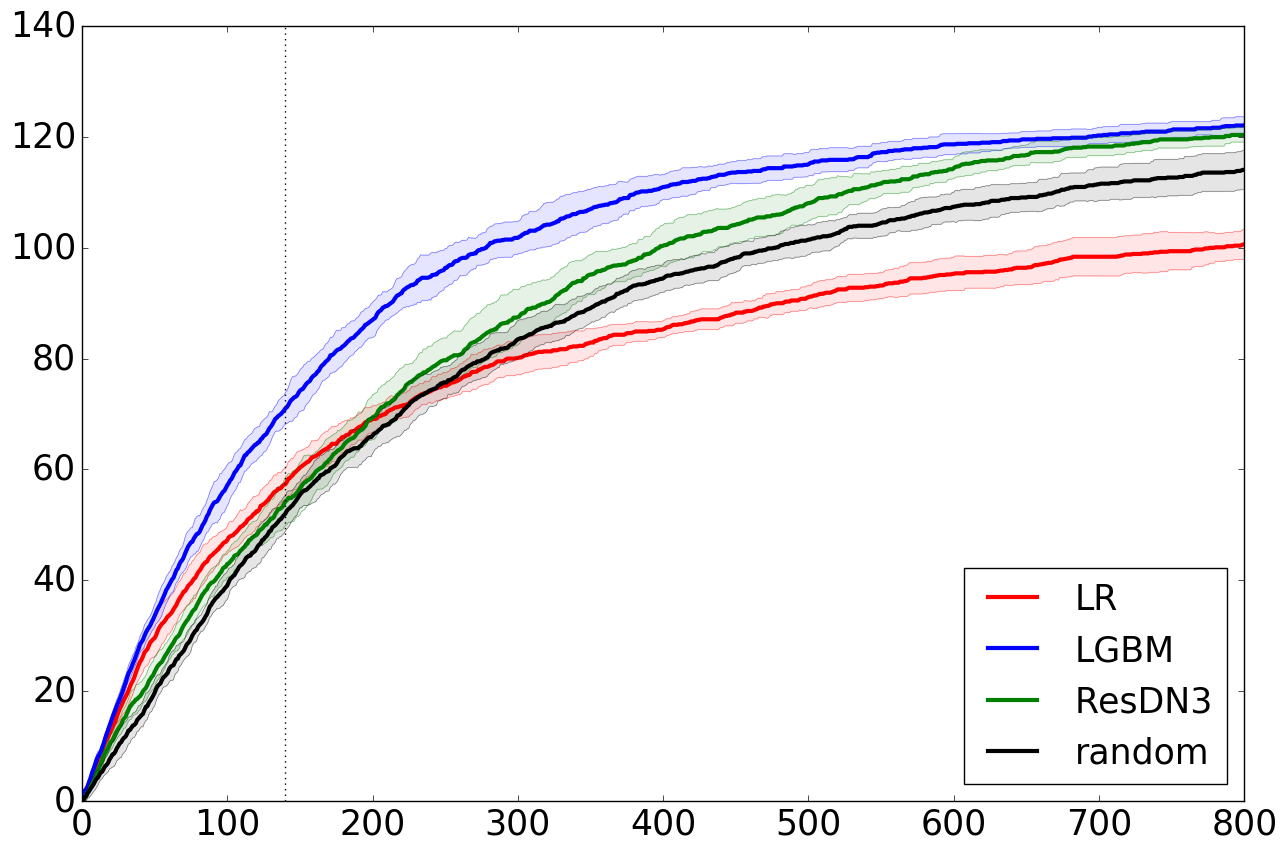

In [73]:
x_fig=np.arange(1,1001)
plt.plot(x_fig,np.mean(Jost_in_LR,axis=0),'r',label='LR',linewidth=3)
plt.plot(x_fig,np.mean(Jost_in_LR,axis=0)+np.std(Jost_in_LR,axis=0),'r',linewidth=0.2)
plt.plot(x_fig,np.mean(Jost_in_LR,axis=0)-np.std(Jost_in_LR,axis=0),'r',linewidth=0.2)
plt.fill_between(x_fig,np.mean(Jost_in_LR,axis=0)+np.std(Jost_in_LR,axis=0),
                 np.mean(Jost_in_LR,axis=0)-np.std(Jost_in_LR,axis=0),color='r',alpha=0.1)
                 

plt.plot(x_fig,np.mean(Jost_in_LGBM,axis=0),'b',label='LGBM',linewidth=3)
plt.plot(x_fig,np.mean(Jost_in_LGBM,axis=0)+np.std(Jost_in_LGBM,axis=0),'b',linewidth=0.2)
plt.plot(x_fig,np.mean(Jost_in_LGBM,axis=0)-np.std(Jost_in_LGBM,axis=0),'b',linewidth=0.2)
plt.fill_between(x_fig,np.mean(Jost_in_LGBM,axis=0)+np.std(Jost_in_LGBM,axis=0),
                 np.mean(Jost_in_LGBM,axis=0)-np.std(Jost_in_LGBM,axis=0),color='b',alpha=0.1)

plt.plot(x_fig,np.mean(Jost_in_ResNet,axis=0),'g',label='ResDN3',linewidth=3)
plt.plot(x_fig,np.mean(Jost_in_ResNet,axis=0)+np.std(Jost_in_ResNet,axis=0),'g',linewidth=0.2)
plt.plot(x_fig,np.mean(Jost_in_ResNet,axis=0)-np.std(Jost_in_ResNet,axis=0),'g',linewidth=0.2)
plt.fill_between(x_fig,np.mean(Jost_in_ResNet,axis=0)+np.std(Jost_in_ResNet,axis=0),
                 np.mean(Jost_in_ResNet,axis=0)-np.std(Jost_in_ResNet,axis=0),color='g',alpha=0.1)


plt.plot(x_fig,np.mean(Jost_in_rand,axis=0),'k',label='random',linewidth=3)
plt.plot(x_fig,np.mean(Jost_in_rand,axis=0)+np.std(Jost_in_rand,axis=0),'k',linewidth=0.2)
plt.plot(x_fig,np.mean(Jost_in_rand,axis=0)-np.std(Jost_in_rand,axis=0),'k',linewidth=0.2)
plt.fill_between(x_fig,np.mean(Jost_in_rand,axis=0)+np.std(Jost_in_rand,axis=0),
                 np.mean(Jost_in_rand,axis=0)-np.std(Jost_in_rand,axis=0),color='k',alpha=0.1)

plt.legend(fontsize=25)
plt.axvline(x=140,color='k',linestyle=':')
plt.xticks(fontsize=25)
           
plt.yticks(fontsize=25)
plt.axis((0,800, 0, 140));

## Windows in blends_140 and not in Jostins

### Combination LR - LGBM

In [74]:
blend_LGBM_LR_reduced_inters={}

for i in range(Nfold):
    intersect_blend_1=[]
    lll=[]
    for k in range(1,140):
        lll=np.nonzero(1*(y_LGBM_orders[i,:]<=k)*(y_LR_orders[i,:]<=k))[0]
        ggg=np.setdiff1d(np.asarray(lll),np.asarray(intersect_blend_1))
        if ggg.shape[0]>0:
            if ggg.shape[0]>1:
                weight_part_inter=np.zeros(ggg.shape[0])
                for h in range(ggg.shape[0]):
                    weight_part_inter[h]=y_LGBM[i,ggg[h]]*y_LR[i,ggg[h]]
                ggg=ggg[np.argsort(weight_part_inter)[::-1]]    
            for z in range(ggg.shape[0]):
                intersect_blend_1.append(ggg[z])
    blend_LGBM_LR_reduced_inters[str(i)]=np.unique(np.asarray(intersect_blend_1))


In [75]:
diff_blend_LGBM_LR_Jost={}
for i in range(len(blend_LGBM_LR_reduced_inters)):
    diff_blend_LGBM_LR_Jost[str(i)]=np.setdiff1d(blend_LGBM_LR_reduced_inters[str(i)],y_Jost_pos)

inter_blend_LGBM_LR_Jost=diff_blend_LGBM_LR_Jost[str(0)]
for i in range(1,len(diff_blend_LGBM_LR_Jost)):
    inter_blend_LGBM_LR_Jost=np.intersect1d(diff_blend_LGBM_LR_Jost[str(i)],inter_blend_LGBM_LR_Jost)

In [76]:
diff_blend_LGBM_LR_Jost_p1={}
for i in range(len(blend_LGBM_LR_reduced_inters)):
    diff_blend_LGBM_LR_Jost_p1[str(i)]=np.setdiff1d(blend_LGBM_LR_reduced_inters[str(i)],y_Jost_pos+1)

inter_blend_LGBM_LR_Jost_p1=diff_blend_LGBM_LR_Jost_p1[str(0)]
for i in range(1,len(diff_blend_LGBM_LR_Jost_p1)):
    inter_blend_LGBM_LR_Jost_p1=np.intersect1d(diff_blend_LGBM_LR_Jost_p1[str(i)],
                                                 inter_blend_LGBM_LR_Jost_p1)

In [77]:
diff_blend_LGBM_LR_Jost_m1={}
for i in range(len(blend_LGBM_LR_reduced_inters)):
    diff_blend_LGBM_LR_Jost_m1[str(i)]=np.setdiff1d(blend_LGBM_LR_reduced_inters[str(i)],y_Jost_pos-1)

inter_blend_LGBM_LR_Jost_m1=diff_blend_LGBM_LR_Jost_m1[str(0)]
for i in range(1,len(diff_blend_LGBM_LR_Jost_m1)):
    inter_blend_LGBM_LR_Jost_m1=np.intersect1d(diff_blend_LGBM_LR_Jost_m1[str(i)],
                                                 inter_blend_LGBM_LR_Jost_m1)


In [78]:
inter_blend_LGBM_LR_Jost_f=np.intersect1d(
    np.intersect1d(inter_blend_LGBM_LR_Jost_m1,inter_blend_LGBM_LR_Jost),
    inter_blend_LGBM_LR_Jost_p1)
inter_blend_LGBM_LR_Jost_f

array([ 988, 1850, 2201, 2202])

### Combination LR - ResNet

In [79]:
blend_LR_ResNet_reduced_inters={}

for i in range(Nfold):
    intersect_blend_1=[]
    lll=[]
    for k in range(1,140):
        lll=np.nonzero(1*(y_LR_orders[i,:]<=k)*(y_ResNet_orders[i,:]<=k))[0]
        ggg=np.setdiff1d(np.asarray(lll),np.asarray(intersect_blend_1))
        if ggg.shape[0]>0:
            if ggg.shape[0]>1:
                weight_part_inter=np.zeros(ggg.shape[0])
                for h in range(ggg.shape[0]):
                    weight_part_inter[h]=y_LR[i,ggg[h]]*y_ResNet[i,ggg[h]]
                ggg=ggg[np.argsort(weight_part_inter)[::-1]]    
            for z in range(ggg.shape[0]):
                intersect_blend_1.append(ggg[z])
    blend_LR_ResNet_reduced_inters[str(i)]=np.unique(np.asarray(intersect_blend_1))


In [80]:
diff_blend_LR_ResNet_Jost={}
for i in range(len(blend_LR_ResNet_reduced_inters)):
    diff_blend_LR_ResNet_Jost[str(i)]=np.setdiff1d(blend_LR_ResNet_reduced_inters[str(i)],y_Jost_pos)

inter_blend_LR_ResNet_Jost=diff_blend_LR_ResNet_Jost[str(0)]
for i in range(1,len(diff_blend_LR_ResNet_Jost)):
    inter_blend_LR_ResNet_Jost=np.intersect1d(diff_blend_LR_ResNet_Jost[str(i)],
                                              inter_blend_LR_ResNet_Jost)


In [81]:
diff_blend_LR_ResNet_Jost_p1={}
for i in range(len(blend_LR_ResNet_reduced_inters)):
    diff_blend_LR_ResNet_Jost_p1[str(i)]=np.setdiff1d(blend_LR_ResNet_reduced_inters[str(i)],y_Jost_pos+1)

inter_blend_LR_ResNet_Jost_p1=diff_blend_LR_ResNet_Jost_p1[str(0)]
for i in range(1,len(diff_blend_LR_ResNet_Jost_p1)):
    inter_blend_LR_ResNet_Jost_p1=np.intersect1d(diff_blend_LR_ResNet_Jost_p1[str(i)],
                                                 inter_blend_LR_ResNet_Jost_p1)


In [82]:
diff_blend_LR_ResNet_Jost_m1={}
for i in range(len(blend_LR_ResNet_reduced_inters)):
    diff_blend_LR_ResNet_Jost_m1[str(i)]=np.setdiff1d(blend_LR_ResNet_reduced_inters[str(i)],y_Jost_pos-1)

inter_blend_LR_ResNet_Jost_m1=diff_blend_LR_ResNet_Jost_m1[str(0)]
for i in range(1,len(diff_blend_LR_ResNet_Jost_m1)):
    inter_blend_LR_ResNet_Jost_m1=np.intersect1d(diff_blend_LR_ResNet_Jost_m1[str(i)],
                                                 inter_blend_LR_ResNet_Jost_m1)


In [83]:
inter_blend_LR_ResNet_Jost_f=np.intersect1d(
    np.intersect1d(inter_blend_LR_ResNet_Jost_m1,inter_blend_LR_ResNet_Jost),
    inter_blend_LR_ResNet_Jost_p1)
inter_blend_LR_ResNet_Jost_f

array([ 988, 1850, 2201])

### Combination LGBM - ResNet

In [84]:
blend_LGBM_ResNet_reduced_inters={}

for i in range(Nfold):
    intersect_blend_1=[]
    lll=[]
    for k in range(1,140):
        lll=np.nonzero(1*(y_LGBM_orders[i,:]<=k)*(y_ResNet_orders[i,:]<=k))[0]
        ggg=np.setdiff1d(np.asarray(lll),np.asarray(intersect_blend_1))
        if ggg.shape[0]>0:
            if ggg.shape[0]>1:
                weight_part_inter=np.zeros(ggg.shape[0])
                for h in range(ggg.shape[0]):
                    weight_part_inter[h]=y_LGBM[i,ggg[h]]*y_ResNet[i,ggg[h]]
                ggg=ggg[np.argsort(weight_part_inter)[::-1]]    
            for z in range(ggg.shape[0]):
                intersect_blend_1.append(ggg[z])
    blend_LGBM_ResNet_reduced_inters[str(i)]=np.unique(np.asarray(intersect_blend_1))


In [85]:
diff_blend_LGBM_ResNet_Jost={}
for i in range(len(blend_LGBM_ResNet_reduced_inters)):
    diff_blend_LGBM_ResNet_Jost[str(i)]=np.setdiff1d(blend_LGBM_ResNet_reduced_inters[str(i)],y_Jost_pos)
    
inter_blend_LGBM_ResNet_Jost=diff_blend_LGBM_ResNet_Jost[str(0)]
for i in range(1,len(diff_blend_LGBM_ResNet_Jost)):
    inter_blend_LGBM_ResNet_Jost=np.intersect1d(diff_blend_LGBM_ResNet_Jost[str(i)],inter_blend_LGBM_ResNet_Jost)


In [86]:
diff_blend_LGBM_ResNet_Jost_p1={}
for i in range(len(blend_LGBM_ResNet_reduced_inters)):
    diff_blend_LGBM_ResNet_Jost_p1[str(i)]=np.setdiff1d(blend_LGBM_ResNet_reduced_inters[str(i)],y_Jost_pos+1)

inter_blend_LGBM_ResNet_Jost_p1=diff_blend_LGBM_ResNet_Jost_p1[str(0)]
for i in range(1,len(diff_blend_LGBM_ResNet_Jost_p1)):
    inter_blend_LGBM_ResNet_Jost_p1=np.intersect1d(diff_blend_LGBM_ResNet_Jost_p1[str(i)],
                                                 inter_blend_LGBM_ResNet_Jost_p1)


In [87]:
diff_blend_LGBM_ResNet_Jost_m1={}
for i in range(len(blend_LGBM_ResNet_reduced_inters)):
    diff_blend_LGBM_ResNet_Jost_m1[str(i)]=np.setdiff1d(blend_LGBM_ResNet_reduced_inters[str(i)],y_Jost_pos-1)

inter_blend_LGBM_ResNet_Jost_m1=diff_blend_LGBM_ResNet_Jost_m1[str(0)]
for i in range(1,len(diff_blend_LGBM_ResNet_Jost_m1)):
    inter_blend_LGBM_ResNet_Jost_m1=np.intersect1d(diff_blend_LGBM_ResNet_Jost_m1[str(i)],
                                                 inter_blend_LGBM_ResNet_Jost_m1)


In [88]:
inter_blend_LGBM_ResNet_Jost_f=np.intersect1d(
    np.intersect1d(inter_blend_LGBM_ResNet_Jost_m1,inter_blend_LGBM_ResNet_Jost),
    inter_blend_LGBM_ResNet_Jost_p1)
inter_blend_LGBM_ResNet_Jost_f

array([ 988, 1850, 2201])

### Combination LR - LGBM - ResNet

In [89]:
blend_LR_LGBM_ResNet_reduced_inters={}

for i in range(Nfold):
    intersect_blend_1=[]
    lll=[]
    for k in range(1,140):
        lll=np.nonzero(1*(y_LR_orders[i,:]<=k)*(y_LGBM_orders[i,:]<=k)*(y_ResNet_orders[i,:]<=k))[0]
        ggg=np.setdiff1d(np.asarray(lll),np.asarray(intersect_blend_1))
        if ggg.shape[0]>0:
            if ggg.shape[0]>1:
                weight_part_inter=np.zeros(ggg.shape[0])
                for h in range(ggg.shape[0]):
                    weight_part_inter[h]=y_LR[i,ggg[h]]*y_LGBM[i,ggg[h]]*y_ResNet[i,ggg[h]]
                ggg=ggg[np.argsort(weight_part_inter)[::-1]]    
            for z in range(ggg.shape[0]):
                intersect_blend_1.append(ggg[z])
    blend_LR_LGBM_ResNet_reduced_inters[str(i)]=np.unique(np.asarray(intersect_blend_1))


In [90]:
diff_blend_LR_LGBM_ResNet_Jost={}
for i in range(len(blend_LR_LGBM_ResNet_reduced_inters)):
    diff_blend_LR_LGBM_ResNet_Jost[str(i)]=np.setdiff1d(blend_LR_LGBM_ResNet_reduced_inters[str(i)],y_Jost_pos)
    
inter_blend_LR_LGBM_ResNet_Jost=diff_blend_LR_LGBM_ResNet_Jost[str(0)]
for i in range(1,len(diff_blend_LR_LGBM_ResNet_Jost)):
    inter_blend_LR_LGBM_ResNet_Jost=np.intersect1d(diff_blend_LR_LGBM_ResNet_Jost[str(i)],inter_blend_LR_LGBM_ResNet_Jost)


In [91]:
diff_blend_LR_LGBM_ResNet_Jost_p1={}
for i in range(len(blend_LR_LGBM_ResNet_reduced_inters)):
    diff_blend_LR_LGBM_ResNet_Jost_p1[str(i)]=np.setdiff1d(blend_LR_LGBM_ResNet_reduced_inters[str(i)],y_Jost_pos+1)

inter_blend_LR_LGBM_ResNet_Jost_p1=diff_blend_LR_LGBM_ResNet_Jost_p1[str(0)]
for i in range(1,len(diff_blend_LR_LGBM_ResNet_Jost_p1)):
    inter_blend_LR_LGBM_ResNet_Jost_p1=np.intersect1d(diff_blend_LR_LGBM_ResNet_Jost_p1[str(i)],
                                                 inter_blend_LR_LGBM_ResNet_Jost_p1)


In [92]:
diff_blend_LR_LGBM_ResNet_Jost_m1={}
for i in range(len(blend_LR_LGBM_ResNet_reduced_inters)):
    diff_blend_LR_LGBM_ResNet_Jost_m1[str(i)]=np.setdiff1d(blend_LR_LGBM_ResNet_reduced_inters[str(i)],y_Jost_pos-1)

inter_blend_LR_LGBM_ResNet_Jost_m1=diff_blend_LR_LGBM_ResNet_Jost_m1[str(0)]
for i in range(1,len(diff_blend_LR_LGBM_ResNet_Jost_m1)):
    inter_blend_LR_LGBM_ResNet_Jost_m1=np.intersect1d(diff_blend_LR_LGBM_ResNet_Jost_m1[str(i)],
                                                 inter_blend_LR_LGBM_ResNet_Jost_m1)


In [93]:
inter_blend_LR_LGBM_ResNet_Jost_f=np.intersect1d(
    np.intersect1d(inter_blend_LR_LGBM_ResNet_Jost_m1,inter_blend_LR_LGBM_ResNet_Jost),
    inter_blend_LR_LGBM_ResNet_Jost_p1)
inter_blend_LR_LGBM_ResNet_Jost_f

array([ 988, 1850, 2201])

### Recognize new SNPs

In [94]:
# Position between the preselected SNPs
presel_numb_SNP_inter_blend_LR_LGBM_ResNet_Jost=np.zeros(inter_blend_LR_LGBM_ResNet_Jost_f.shape[0])
for i in range(inter_blend_LR_LGBM_ResNet_Jost_f.shape[0]):
    which_pos_all=np.nonzero(y_presel_pos==inter_blend_LR_LGBM_ResNet_Jost_f[i])[0]
    which_one_rel=np.argmax(np.abs(y_LR_prel[which_pos_all]))
    presel_numb_SNP_inter_blend_LR_LGBM_ResNet_Jost[i]=which_pos_all[which_one_rel]
    
presel_numb_SNP_inter_blend_LR_LGBM_ResNet_Jost=presel_numb_SNP_inter_blend_LR_LGBM_ResNet_Jost.astype(int)

In [95]:
# Absolute position in DATA.map file
# (remember: SNP_QC = All_SNP_QC[presel_QC], and All_SNP_QC is the list of SNPs passing Quality control)

new_SNP_numb=SNP_QC[presel_numb_SNP_inter_blend_LR_LGBM_ResNet_Jost]

In [96]:

print(ALL_SNPs_chrs[new_SNP_numb])
print(ALL_SNPs_pos[new_SNP_numb])
print(ALL_SNPs_names[new_SNP_numb])


[2 5 6]
[242386014  38903489  32734227]
['rs35320439' 'rs395157' 'rs6928482']


# Comparison within models (on folds)

In [97]:
y_LR_orders=y_all_models_orders['y_LR_orders']

step=1000
inters_LR_all=np.zeros((step,int(Nfold*(Nfold-1)/2)))

for N_coeff in range(1,step):
    k=0
    for i in range(Nfold-1):
        for j in range(i+1,Nfold):
            inters_LR_all[N_coeff,k]=(np.intersect1d(y_LR_orders[i,:N_coeff],y_LR_orders[j,:N_coeff]).shape[0])/N_coeff
            k=k+1


In [98]:
y_LR_orders=y_all_models_orders['y_LR_orders']
y_LGBM_orders=y_all_models_orders['y_LGBM_orders']
y_ResNet_orders=y_all_models_orders['y_ResNet_orders']
y_rand_orders=y_all_models_orders['y_rand_orders']

step=1000
inters_LR_all=np.zeros((step,int(Nfold*(Nfold-1)/2)))
inters_LGBM_all=np.zeros((step,int(Nfold*(Nfold-1)/2)))
inters_ResNet_all=np.zeros((step,int(Nfold*(Nfold-1)/2)))
inters_rand_all=np.zeros((step,int(Nfold*(Nfold-1)/2)))

for nnn in range(step):
    Max_ord=nnn+1
    k=0
    for i in range(Nfold-1):
        for j in range(i+1,Nfold):
            inters_LR_all[nnn,k]=np.sum((y_LR_orders[i,:]<=Max_ord)*(y_LR_orders[j,:]<=Max_ord))/Max_ord
            inters_LGBM_all[nnn,k]=np.sum((y_LGBM_orders[i,:]<=Max_ord)*(y_LGBM_orders[j,:]<=Max_ord))/Max_ord
            inters_ResNet_all[nnn,k]=np.sum((y_ResNet_orders[i,:]<=Max_ord)*(y_ResNet_orders[j,:]<=Max_ord))/Max_ord
            inters_rand_all[nnn,k]=np.sum((y_rand_orders[i,:]<=Max_ord)*(y_rand_orders[j,:]<=Max_ord))/Max_ord
            k=k+1

In [99]:
inters_LR_all_mean=np.mean(inters_LR_all,axis=1)
inters_LR_all_std=np.std(inters_LR_all,axis=1)

inters_LGBM_all_mean=np.mean(inters_LGBM_all,axis=1)
inters_LGBM_all_std=np.std(inters_LGBM_all,axis=1)

inters_ResNet_all_mean=np.mean(inters_ResNet_all,axis=1)
inters_ResNet_all_std=np.std(inters_ResNet_all,axis=1)

inters_rand_all_mean=np.mean(inters_rand_all,axis=1)
inters_rand_all_std=np.std(inters_rand_all,axis=1)

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text yticklabel objects>)

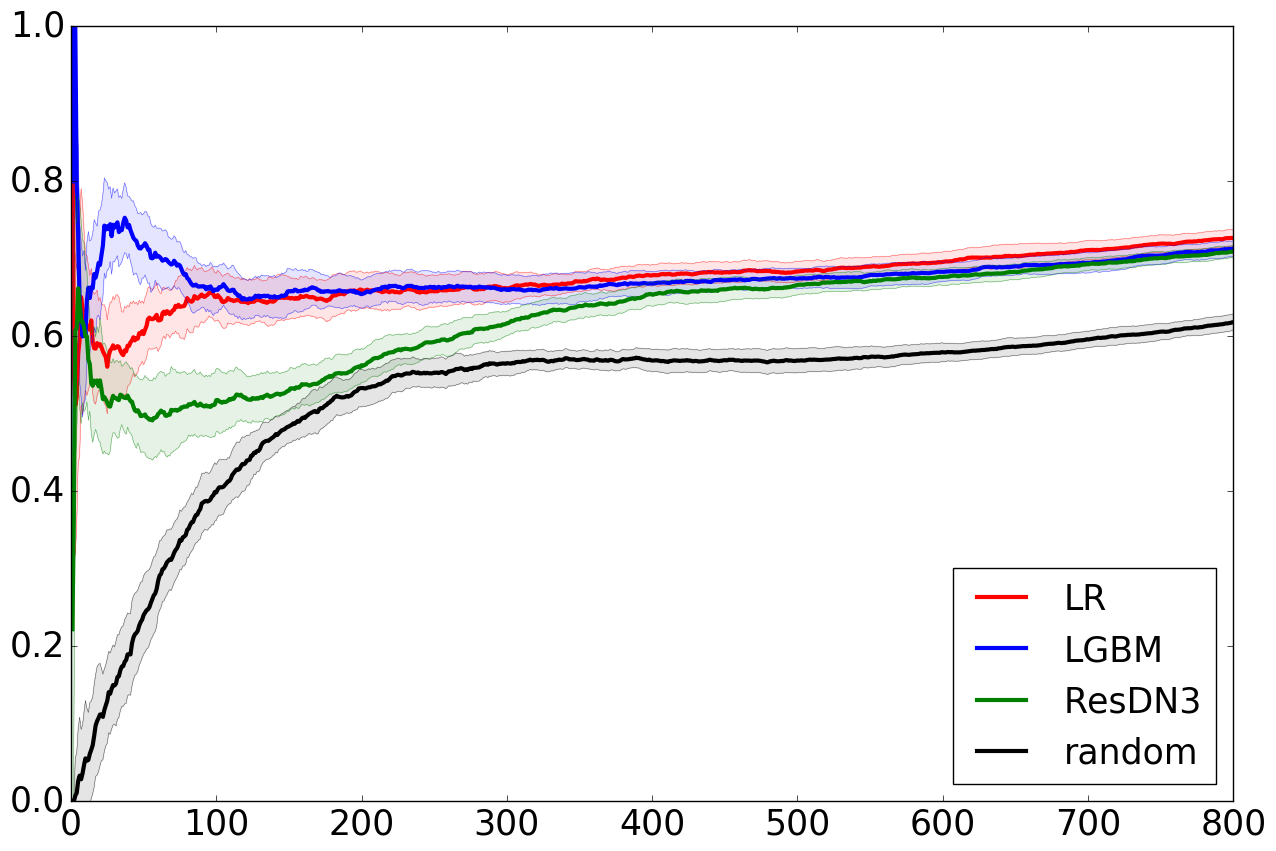

In [100]:
x_fig=np.arange(1,1001)
plt.plot(x_fig,inters_LR_all_mean,'r',linewidth=3, label="LR")
plt.plot(x_fig,inters_LR_all_mean+inters_LR_all_std,'r',linewidth=0.2)
plt.plot(x_fig,inters_LR_all_mean-inters_LR_all_std,'r',linewidth=0.2)
plt.fill_between(x_fig,inters_LR_all_mean+inters_LR_all_std,inters_LR_all_mean-inters_LR_all_std,color='r',alpha=0.1)

plt.plot(x_fig,inters_LGBM_all_mean,'b',linewidth=3, label="LGBM")
plt.plot(x_fig,inters_LGBM_all_mean+inters_LGBM_all_std,'b',linewidth=0.2)
plt.plot(x_fig,inters_LGBM_all_mean-inters_LGBM_all_std,'b',linewidth=0.2)
plt.fill_between(x_fig,inters_LGBM_all_mean+inters_LGBM_all_std,inters_LGBM_all_mean-inters_LGBM_all_std,color='b',alpha=0.1)


plt.plot(x_fig,inters_ResNet_all_mean,'g',linewidth=3, label="ResDN3")
plt.plot(x_fig,inters_ResNet_all_mean+inters_ResNet_all_std,'g',linewidth=0.2)
plt.plot(x_fig,inters_ResNet_all_mean-inters_ResNet_all_std,'g',linewidth=0.2)
plt.fill_between(x_fig,inters_ResNet_all_mean+inters_ResNet_all_std,inters_ResNet_all_mean-inters_ResNet_all_std,color='g',alpha=0.1)


plt.plot(x_fig,inters_rand_all_mean,'k',linewidth=3, label="random")
plt.plot(x_fig,inters_rand_all_mean+inters_rand_all_std,'k',linewidth=0.2)
plt.plot(x_fig,inters_rand_all_mean-inters_rand_all_std,'k',linewidth=0.2)
plt.fill_between(x_fig,inters_rand_all_mean+inters_rand_all_std,inters_rand_all_mean-inters_rand_all_std,color='k',alpha=0.1)


plt.axis((0,800,0,1))
plt.legend(fontsize=25)
plt.xticks(fontsize=25)
           
plt.yticks(fontsize=25)
# plt.title('Proportion of common features between the first x features \n (comparing same models)', fontsize=15)

# Comparison between models

In [101]:
y_LR_orders_mean=y_all_models_orders_mean['y_LR_orders_mean']
y_LGBM_orders_mean=y_all_models_orders_mean['y_LGBM_orders_mean']
y_ResNet_orders_mean=y_all_models_orders_mean['y_ResNet_orders_mean']
y_rand_orders_mean=y_all_models_orders_mean['y_rand_orders_mean']


intersect_LR_LGBM=np.zeros(2000)
intersect_LGBM_ResNet=np.zeros(2000)
intersect_LR_ResNet=np.zeros(2000)
intersect_LR_rand=np.zeros(2000)
intersect_LGBM_rand=np.zeros(2000)
intersect_ResNet_rand=np.zeros(2000)
intersect_rand_rand=np.zeros(2000)

for nnn in range(2000):
    Max_ord=nnn+1
    intersect_LR_LGBM[nnn]=np.sum((y_LR_orders_mean<=Max_ord)*(y_LGBM_orders_mean<=Max_ord))/Max_ord
    intersect_LGBM_ResNet[nnn]=np.sum((y_LGBM_orders_mean<=Max_ord)*(y_ResNet_orders_mean<=Max_ord))/Max_ord
    intersect_LR_ResNet[nnn]=np.sum((y_ResNet_orders_mean<=Max_ord)*(y_LR_orders_mean<=Max_ord))/Max_ord
#     
    intersect_LR_rand[nnn]=np.sum((y_rand_orders_mean<=Max_ord)*(y_LR_orders_mean<=Max_ord))/Max_ord
    intersect_LGBM_rand[nnn]=np.sum((y_rand_orders_mean<=Max_ord)*(y_LGBM_orders_mean<=Max_ord))/Max_ord
    intersect_ResNet_rand[nnn]=np.sum((y_rand_orders_mean<=Max_ord)*(y_ResNet_orders_mean<=Max_ord))/Max_ord

        

(1, 1450, 0, 1.1)

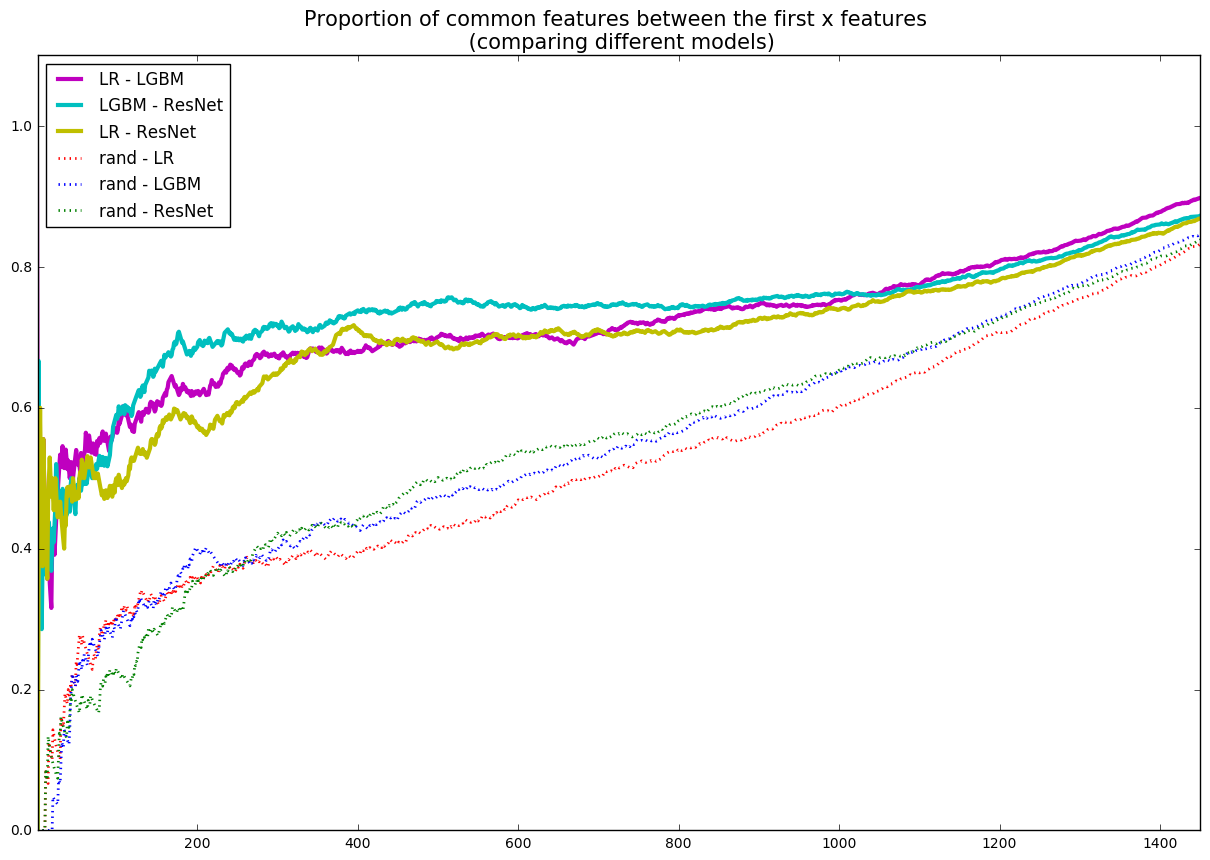

In [102]:
plt.plot(intersect_LR_LGBM,'m',linewidth=3,label='LR - LGBM')


plt.plot(intersect_LGBM_ResNet,'c',linewidth=3,label='LGBM - ResNet')
plt.plot(intersect_LR_ResNet,'y',linewidth=3,label='LR - ResNet')
# 
plt.plot(intersect_LR_rand,':r',linewidth=2,label='rand - LR')
plt.plot(intersect_LGBM_rand,':b',linewidth=2,label='rand - LGBM')
plt.plot(intersect_ResNet_rand,':g',linewidth=2,label='rand - ResNet')
# 
plt.legend(fontsize=12)
plt.title('Proportion of common features between the first x features \n (comparing different models)', fontsize=15)
plt.axis((1,1450,0,1.1))

In [103]:
NMAX=1000

intersect_LR_LGBM=np.zeros((Nfold,NMAX))
intersect_LGBM_ResNet=np.zeros((Nfold,NMAX))
intersect_LR_ResNet=np.zeros((Nfold,NMAX))
intersect_LR_rand=np.zeros((Nfold,NMAX))
intersect_LGBM_rand=np.zeros((Nfold,NMAX))
intersect_ResNet_rand=np.zeros((Nfold,NMAX))
intersect_rand_rand=np.zeros((Nfold,NMAX))

for i in range(Nfold):
    for nnn in range(NMAX):
        Max_ord=nnn+1
        intersect_LR_LGBM[i,nnn]=np.sum((y_LR_orders[i,:]<=Max_ord)*(y_LGBM_orders[i,:]<=Max_ord))/Max_ord
        intersect_LGBM_ResNet[i,nnn]=np.sum((y_LGBM_orders[i,:]<=Max_ord)*(y_ResNet_orders[i,:]<=Max_ord))/Max_ord
        intersect_LR_ResNet[i,nnn]=np.sum((y_ResNet_orders[i,:]<=Max_ord)*(y_LR_orders[i,:]<=Max_ord))/Max_ord
    #     
        intersect_LR_rand[i,nnn]=np.sum((y_rand_orders[i,:]<=Max_ord)*(y_LR_orders[i,:]<=Max_ord))/Max_ord
        intersect_LGBM_rand[i,nnn]=np.sum((y_rand_orders[i,:]<=Max_ord)*(y_LGBM_orders[i,:]<=Max_ord))/Max_ord
        intersect_ResNet_rand[i,nnn]=np.sum((y_rand_orders[i,:]<=Max_ord)*(y_ResNet_orders[i,:]<=Max_ord))/Max_ord


(1, 800, 0, 1)

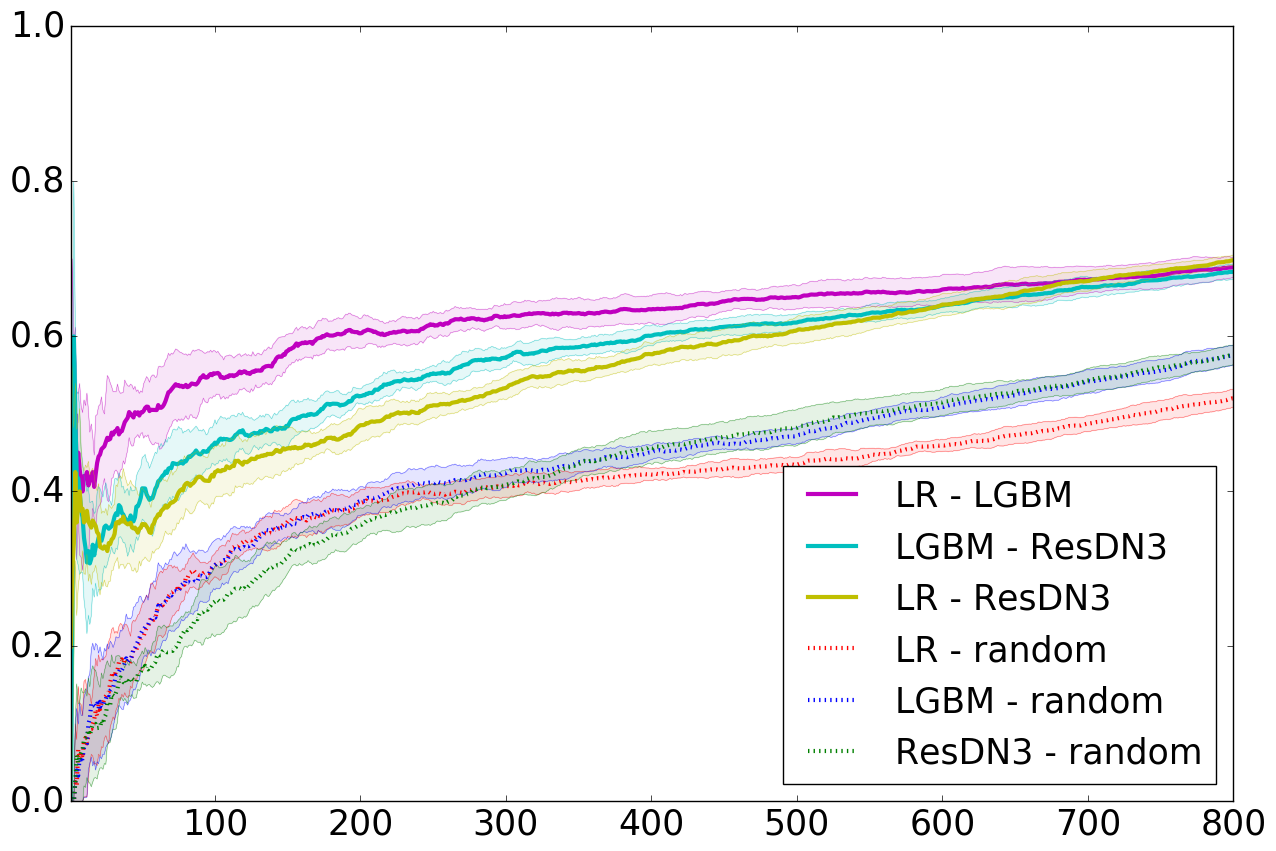

In [104]:
x_fig=np.arange(1,NMAX+1)

plt.plot(x_fig,np.mean(intersect_LR_LGBM,axis=0),'m',linewidth=3,label='LR - LGBM')
plt.plot(x_fig,np.mean(intersect_LR_LGBM,axis=0)+ np.std(intersect_LR_LGBM,axis=0),'m',linewidth=0.2)
plt.plot(x_fig,np.mean(intersect_LR_LGBM,axis=0)-np.std(intersect_LR_LGBM,axis=0),'m',linewidth=0.2)
plt.fill_between(x_fig,np.mean(intersect_LR_LGBM,axis=0)+np.std(intersect_LR_LGBM,axis=0),
                 np.mean(intersect_LR_LGBM,axis=0)-np.std(intersect_LR_LGBM,axis=0),color='m',alpha=0.1)


plt.plot(x_fig,np.mean(intersect_LGBM_ResNet,axis=0),'c',linewidth=3,label='LGBM - ResDN3')
plt.plot(x_fig,np.mean(intersect_LGBM_ResNet,axis=0)+ np.std(intersect_LGBM_ResNet,axis=0),'c',linewidth=0.2)
plt.plot(x_fig,np.mean(intersect_LGBM_ResNet,axis=0)-np.std(intersect_LGBM_ResNet,axis=0),'c',linewidth=0.2)
plt.fill_between(x_fig,np.mean(intersect_LGBM_ResNet,axis=0)+np.std(intersect_LGBM_ResNet,axis=0),
                 np.mean(intersect_LGBM_ResNet,axis=0)-np.std(intersect_LGBM_ResNet,axis=0),color='c',alpha=0.1)

plt.plot(x_fig,np.mean(intersect_LR_ResNet,axis=0),'y',linewidth=3,label='LR - ResDN3')
plt.plot(x_fig,np.mean(intersect_LR_ResNet,axis=0)+ np.std(intersect_LR_ResNet,axis=0),'y',linewidth=0.2)
plt.plot(x_fig,np.mean(intersect_LR_ResNet,axis=0)-np.std(intersect_LR_ResNet,axis=0),'y',linewidth=0.2)
plt.fill_between(x_fig,np.mean(intersect_LR_ResNet,axis=0)+np.std(intersect_LR_ResNet,axis=0),
                 np.mean(intersect_LR_ResNet,axis=0)-np.std(intersect_LR_ResNet,axis=0),color='y',alpha=0.1)



plt.plot(x_fig,np.mean(intersect_LR_rand,axis=0),':r',linewidth=3,label='LR - random')
plt.plot(x_fig,np.mean(intersect_LR_rand,axis=0)+ np.std(intersect_LR_rand,axis=0),'r',linewidth=0.2)
plt.plot(x_fig,np.mean(intersect_LR_rand,axis=0)-np.std(intersect_LR_rand,axis=0),'r',linewidth=0.2)
plt.fill_between(x_fig,np.mean(intersect_LR_rand,axis=0)+np.std(intersect_LR_rand,axis=0),
                 np.mean(intersect_LR_rand,axis=0)-np.std(intersect_LR_rand,axis=0),color='r',alpha=0.1)

plt.plot(x_fig,np.mean(intersect_LGBM_rand,axis=0),':b',linewidth=3,label='LGBM - random')
plt.plot(x_fig,np.mean(intersect_LGBM_rand,axis=0)+ np.std(intersect_LGBM_rand,axis=0),'b',linewidth=0.2)
plt.plot(x_fig,np.mean(intersect_LGBM_rand,axis=0)-np.std(intersect_LGBM_rand,axis=0),'b',linewidth=0.2)
plt.fill_between(x_fig,np.mean(intersect_LGBM_rand,axis=0)+np.std(intersect_LGBM_rand,axis=0),
                 np.mean(intersect_LGBM_rand,axis=0)-np.std(intersect_LGBM_rand,axis=0),color='b',alpha=0.1)


plt.plot(x_fig,np.mean(intersect_ResNet_rand,axis=0),':g',linewidth=3,label='ResDN3 - random')
plt.plot(x_fig,np.mean(intersect_ResNet_rand,axis=0)+ np.std(intersect_ResNet_rand,axis=0),'g',linewidth=0.2)
plt.plot(x_fig,np.mean(intersect_ResNet_rand,axis=0)-np.std(intersect_ResNet_rand,axis=0),'g',linewidth=0.2)
plt.fill_between(x_fig,np.mean(intersect_ResNet_rand,axis=0)+np.std(intersect_ResNet_rand,axis=0),
                 np.mean(intersect_ResNet_rand,axis=0)-np.std(intersect_ResNet_rand,axis=0),color='g',alpha=0.1)

plt.legend(fontsize=25)
plt.xticks(fontsize=25)
           
plt.yticks(fontsize=25)
# plt.title('Proportion of common features between the first x features \n (comparing different models)', fontsize=15)
plt.axis((1,800,0,1))